# Bottle cap highlighter
This notebook was created as an experiment, using k-means clustering to determine bottle caps in pictures

In [25]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']=100
import numpy as np
from imageio import imread
from skimage.transform import rescale
from skimage.color import rgb2lab, lab2rgb
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
import cv2
from tensorflow.keras.applications import mobilenet_v2

# Set up neural network
model = mobilenet_v2.MobileNetV2(weights='imagenet')

Load sample images, reshape them, reducing the workload, and display it.

In [26]:
def rescaleImage(raw_image, desired_height=244):
    return rescale(raw_image, desired_height/raw_image.shape[0], mode='reflect', multichannel=True, anti_aliasing=True)

In [ ]:
class Overview:
    def __init__(self,image_path,cv2_name):
        self.image_path = image_path,
        self.image = rescaleImage(imread(image_path_prefix+image_path))
        self.cv2_name = cv2_name
        self.base_accuracy = None
        self.k_accuracies = None

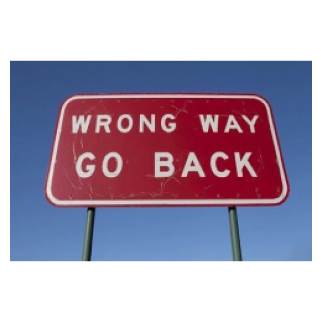

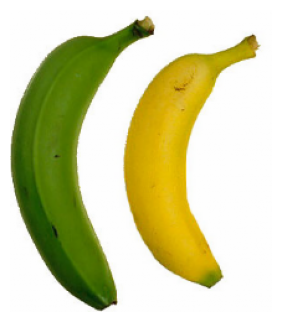

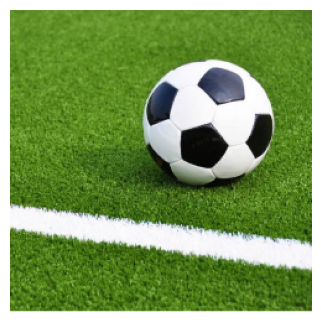

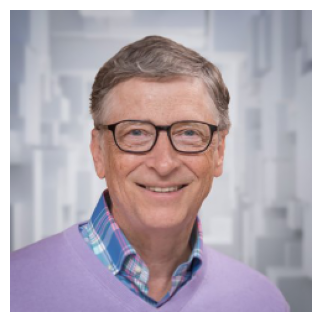

In [40]:
image_path_prefix = "samples/"
image_paths = ['roadsign.jpg','bananas.jpg','soccerball.jpg']

images = [rescaleImage(imread(image_path_prefix+image_path),desired_height) for image_path in image_paths]

for image in images:
    plt.figure()
    plt.imshow(image)
    plt.axis('off');

In [54]:
########## Get base accuracy ##########
base_accuracies = []

for i, image in enumerate(images):
    image = image*np.array([255,255,255])
    min_dim = np.min(image.shape[0:2])
    resized_image = cv2.resize(image[0:min_dim, 0:min_dim, :], (224, 224))
    
    # Update classification
    processed_image = mobilenet_v2.preprocess_input(np.expand_dims(resized_image, axis=0))
    
    
    predictions = model.predict(processed_image)
    label = mobilenet_v2.decode_predictions(predictions)
    
    print(image_paths[i])
    for name, desc, score in mobilenet_v2.decode_predictions(predictions)[0]:
        print('- {} ({:.2f}%)'.format(desc, 100 * score))


roadsign.jpg
- street_sign (93.79%)
- digital_clock (1.24%)
- bakery (0.33%)
- scoreboard (0.23%)
- buckle (0.22%)
bananas.jpg
- banana (92.91%)
- bell_pepper (0.87%)
- zucchini (0.46%)
- slug (0.23%)
- butternut_squash (0.22%)
soccerball.jpg
- soccer_ball (95.80%)
- golf_ball (0.14%)
- croquet_ball (0.11%)
- volleyball (0.07%)
- football_helmet (0.07%)
gates.jpg
- lab_coat (49.45%)
- suit (5.00%)
- academic_gown (4.02%)
- oboe (2.60%)
- Windsor_tie (1.94%)


Cluster the image pixels, treating colors as 3-dimensional points

In [311]:
############ Clustering algorithems ############

def cluster_assignments(X, Y):
    return np.argmin(euclidean_distances(X,Y), axis=1)

def cluster_analysis(pixels,K):
    centers = np.array(
        [pixels.mean(0) + (np.random.randn(3)/10) # Because X is an array of pixels each presented by an array of [R,G,B]. X.mean(0) results in an array of [mean(R), mean(G), mean(B)]
         for _ in range(K)])
    y_kmeans = cluster_assignments(pixels, centers)
    previous_cluster_assignments = [];

    # repeat estimation a number of times (could do something smarter, like comparing if clusters change)
    while not np.array_equal(y_kmeans, previous_cluster_assignments):
        # move the centers to the mean of their assigned points (if any)
        for i, c in enumerate(centers):
            points = pixels[y_kmeans == i]
            if len(points):
                centers[i] = points.mean(0)

        previous_cluster_assignments = y_kmeans.copy()
        # assign each point to the closest center
        y_kmeans = cluster_assignments(pixels, centers)
    
    return {
        "assignments": y_kmeans,
        "centers": centers
    }

def average_variance(values, assignments, centers, K):
    values = np.array(values)
    assignments = np.array(assignments)
    centers = np.array(centers)
    clusterVariances = []

    for i in range(K):
        clusterValues = values[assignments==i]
        clusterCenter = centers[i-1]
        distance = [abs(math.dist(value,clusterCenter)) for value in clusterValues]

        if len(clusterValues):
            clusterVariances.append(np.sum(distance)/len(clusterValues))
        else:
            clusterVariances.append(0)

    return sum(clusterVariances)/K

In [315]:
pixels = rgb2lab(image).reshape(-1, 3) # Lab has a bigger color space
starting_K = 3
K = starting_K - 1
K_variances = []

import time
start_time=time.time()

while len(K_variances) < 3\
    or abs(K_variances[K - starting_K - 1] - K_variances[K - starting_K]) \
     > abs((K_variances[K - starting_K - 1] - K_variances[K - starting_K - 2])):
    K += 1
    
    K_values = cluster_analysis(pixels,K)    
    K_variances.append(average_variance(pixels,K_values["assignments"], K_values["centers"], K))

optimal_K =  K - 1
print("Optimal K: ", optimal_K)
print(K_variances)
optimal_values = cluster_analysis(pixels,optimal_K)
assignments = optimal_values["assignments"]
centers = optimal_values["centers"]
    
end_time=time.time()-start_time
print("Time elapsed: ", end_time)

color_clustered_image = lab2rgb(centers[assignments,:].reshape(shape[0], shape[1], 3))

Optimal K:  4
[52.33494308523436, 39.458149429213506, 47.93761633527235]
Time elapsed:  0.42351865768432617


Plot the result as an image, where each pixel is colored by its cluster mean

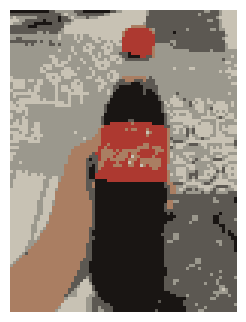

In [313]:
plt.figure()
plt.imshow(color_clustered_image)
plt.axis('off');

In [303]:
class Pixel:
    def __init__(self, coordinates, lab):
        self.coordinates = coordinates
        self.pixel = lab

def get_2D_pixel_coordinates_map(array):
    shape = array.shape
    coordinate_map = [[None]*shape[1] for _ in range(shape[0])]

    i = shape[2] - 1
    for (y, x, z), element in np.ndenumerate(array):
        if (z < i):
            continue

        coordinate_map[y][x] = Pixel([x,y],array[y,x])
    
    return np.array(coordinate_map)

In [308]:
import math

def get_connected_groups(cluster):
    non_used_pixels = np.copy(cluster).tolist()
    groups = []
    
    while len(non_used_pixels) > 0:
        starting_pixel=non_used_pixels[0]
        group = [starting_pixel]
        non_used_pixels.remove(starting_pixel)
        
        iteration_pixels = [starting_pixel]
        new_pixels = []
        while len(iteration_pixels) > 0:
            for group_pixel in iteration_pixels:
                for pixel in non_used_pixels:
                    if math.dist(group_pixel.coordinates, pixel.coordinates):
                        new_pixels.append(pixel)
            
            for new_pixel in new_pixels:
                non_used_pixels.remove(new_pixel)
            
            group.extend(new_pixels)
            iteration_pixels = new_pixels
            new_pixels.clear()
        
        groups.append(group)

def get_clusters_separated_by_connection(clusters):
    connected_groups = []
    for cluster in clusters:
        connected_groups.append(get_connected_groups(cluster))
    
    return connected_groups

In [310]:
coordinate_map = get_2D_pixel_coordinates_map(color_clustered_image).reshape(-1,1)
color_clusters = [coordinate_map[assignments == i] for i in range(optimal_K)]
connected_clusters = get_clusters_separated_by_connection(color_clusters)
print(connected_clusters)

[None, None, None, None]
